In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [6]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3 

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Cats",
    shuffle = True,
    image_size  = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
    
)

Found 2399 files belonging to 12 classes.


In [8]:
class_names = dataset.class_names
class_names

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_blue',
 'Siamese',
 'Sphynx']

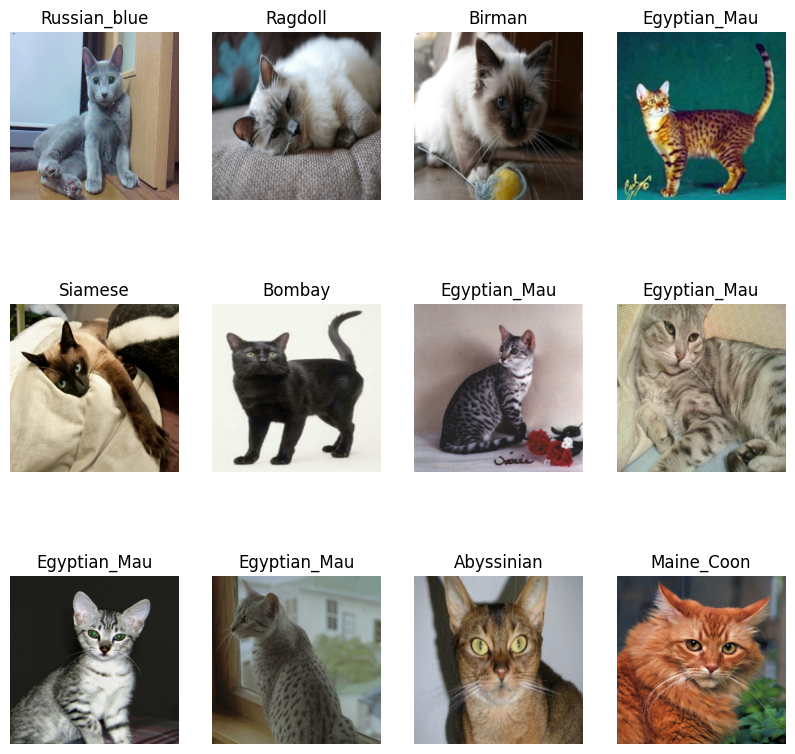

In [9]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range (12):
        plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [10]:
def get_dataset_partitions_tf(dataset, train_split=0.8, validation_split=0.1, test_split=0.1, shuffle=True, shuffle_size = 10000):
    dataset_size = len (dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=11)
    train_size = int(train_split * dataset_size)
    validation_size = int(validation_split * dataset_size)
    
    train_dataset = dataset.take(train_size)
    validation_dataset = dataset.skip(train_size).take(validation_size)
    test_dataset = dataset.skip(train_size).skip(validation_size)

    return train_dataset, validation_dataset, test_dataset 

In [11]:
train_dataset,validation_dataset, test_dataset = get_dataset_partitions_tf(dataset)
len(train_dataset)


60

In [12]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) 
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) 
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) 

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE), 
    layers.Rescaling(1.0 / 255)              
])

In [14]:
data_argumentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

In [38]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

base_model = tf.keras.applications.VGG16(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
    include_top=False, 
    weights='imagenet'  
)

base_model.trainable = False

model = models.Sequential([
    resize_and_rescale,  
    data_argumentation, 
    base_model,        
    layers.GlobalAveragePooling2D(),  
    layers.Dense(128, activation='relu'),  
    layers.Dropout(0.5), 
    layers.Dense(12, activation='softmax'), 
])

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (32, 8, 8, 512)             │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (32, 512)                   │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (32, 128)                   │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (32, 128)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (32, 12)                    │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,781,900 (56.39 MB)

 Trainable params: 67,212 (262.55 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [39]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  
    metrics=['accuracy'],
)


In [41]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
EPOCHS = 50

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=validation_dataset,
    callbacks=[early_stopping]  
)


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 376s 6s/step - accuracy: 0.1122 - loss: 2.5352 - val_accuracy: 0.2915 - val_loss: 2.3188
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 340s 6s/step - accuracy: 0.2016 - loss: 2.3372 - val_accuracy: 0.2646 - val_loss: 2.1718
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 326s 5s/step - accuracy: 0.2416 - loss: 2.2040 - val_accuracy: 0.4843 - val_loss: 1.9859
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 315s 5s/step - accuracy: 0.2787 - loss: 2.1079 - val_accuracy: 0.4574 - val_loss: 1.8604
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 315s 5s/step - accuracy: 0.2906 - loss: 2.0060 - val_accuracy: 0.5022 - val_loss: 1.7553
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 314s 5s/step - accuracy: 0.3111 - loss: 1.9282 - val_accuracy: 0.5516 - val_loss: 1.6644
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 316s 5s/step - accuracy: 0.3390 - loss: 1.8544 - val_accuracy: 0.5336 - val_loss: 1.6171
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 314s 5s/step - accuracy: 0.3453 - loss: 1.8264 - val_accuracy: 0.5471 - v

In [42]:
sсores = model.evaluate(test_dataset)

8/8 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step - accuracy: 0.7282 - loss: 0.9044


In [43]:
scores

NameError: name 'scores' is not defined

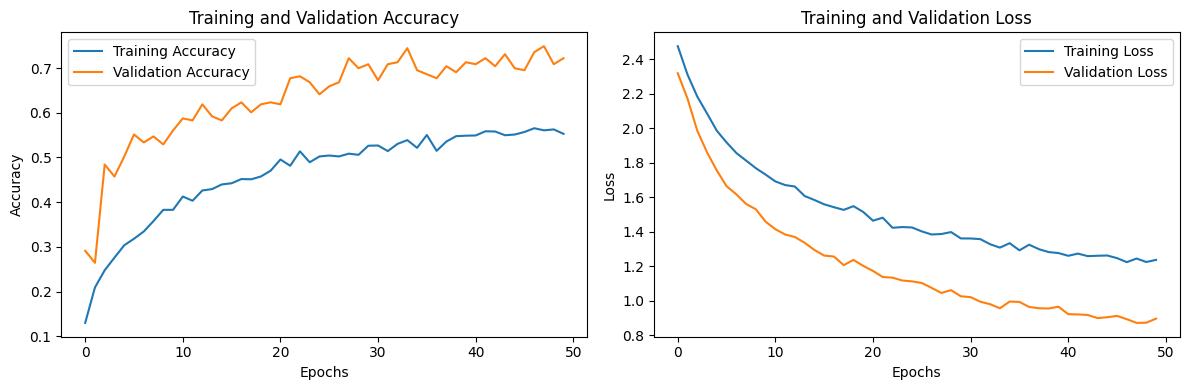

In [46]:
import matplotlib.pyplot as plt

# Assuming 'history' is the output from model.fit()

# Plot accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


First image to predict


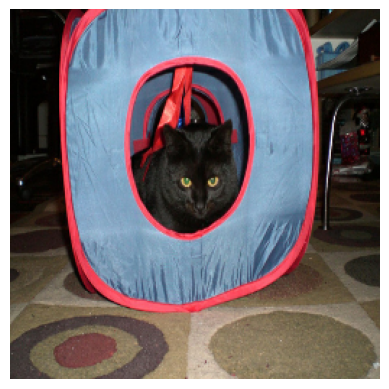

Actual label: Bombay
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted label: Bombay


In [55]:
import numpy as np

for images_batch, labels_batch in test_dataset.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    plt.axis('off')
    plt.show()
    print("Actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


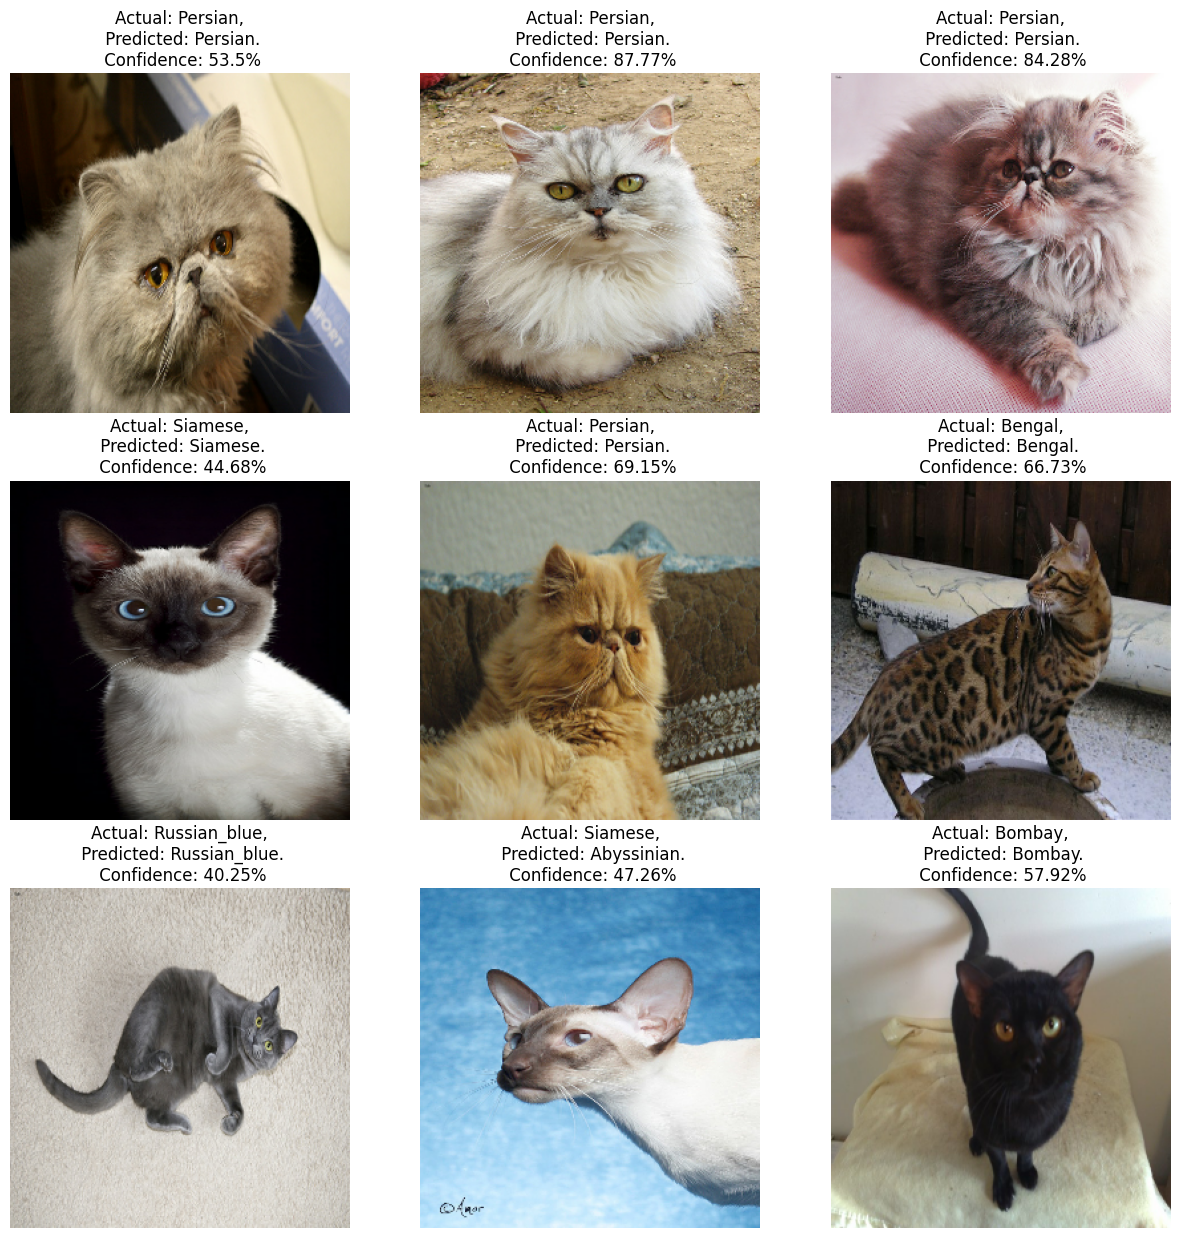

In [58]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)  

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize = (15,15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")


In [59]:
model_version = 3
model.export(f"../models/{model_version}") 

INFO:tensorflow:Assets written to: ../models/3\assets


INFO:tensorflow:Assets written to: ../models/3\assets


Saved artifact at '../models/3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_131')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  1954773300432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1954773301392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1954773300624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1954773301776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1954773289296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1954773288528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1954773288720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1954773287760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1954773287184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1954773290064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1954773287376: TensorSpec(shape=()

In [61]:
model_version = 3
model.save(f"../models/{model_version}.keras") 